In [1]:
import heapq
import math
import os
import re
import time
from typing import List, Optional, Tuple

import aocd
import numpy as np
from IPython.display import HTML, clear_output, display
from scipy.ndimage import convolve

from collections import deque

In [2]:
p = aocd.get_puzzle(year=2024, day=12)

In [3]:
def get_data(test_data: bool = False):
    if test_data:
        data = p.examples[1].input_data
    else:
        data = p.input_data
    return data

In [4]:
def process_data(data):
    grid = [list(l) for l in data.split("\n")]
    grid = np.array(grid)
    return grid

In [5]:
data = get_data(test_data=False)
grid = process_data(data)

directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

In [6]:
grid.shape

(140, 140)

In [7]:
def count_corners(grid, positions, label):
    """Count corners for a region (corners = sides)."""
    rows, cols = grid.shape
    positions_set = set(positions)
    
    def is_same(r, c):
        """Check if position belongs to this region."""
        return (r, c) in positions_set
    
    corners = 0
    
    # The four corner directions: (orthogonal1, orthogonal2, diagonal)
    corner_checks = [
        ((-1, 0), (0, -1), (-1, -1)),  # top-left
        ((-1, 0), (0, 1), (-1, 1)),    # top-right
        ((1, 0), (0, -1), (1, -1)),    # bottom-left
        ((1, 0), (0, 1), (1, 1)),      # bottom-right
    ]
    
    for r, c in positions:
        for (dr1, dc1), (dr2, dc2), (drd, dcd) in corner_checks:
            neighbor1 = is_same(r + dr1, c + dc1)
            neighbor2 = is_same(r + dr2, c + dc2)
            diagonal = is_same(r + drd, c + dcd)
            
            # Outer corner: both orthogonal neighbors are outside
            if not neighbor1 and not neighbor2:
                corners += 1
            
            # Inner corner: both orthogonal neighbors inside, diagonal outside
            if neighbor1 and neighbor2 and not diagonal:
                corners += 1
    
    return corners


def flood_fill(grid, start, visited):
    """BFS flood fill that returns area, perimeter, and sides for one region."""
    rows, cols = grid.shape
    label = grid[start]
    queue = deque([start])
    visited.add(start)
    
    area = 0
    perimeter = 0
    positions = []  # Track all positions for corner counting
    
    while queue:
        r, c = queue.popleft()
        area += 1
        positions.append((r, c))
        
        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            
            if nr < 0 or nr >= rows or nc < 0 or nc >= cols:
                perimeter += 1
            elif grid[nr, nc] != label:
                perimeter += 1
            elif (nr, nc) not in visited:
                visited.add((nr, nc))
                queue.append((nr, nc))
    
    sides = count_corners(grid, positions, label)
    
    return label, area, perimeter, sides


def find_all_regions(grid):
    """Find all regions and their area/perimeter/sides."""
    visited = set()
    regions = []
    
    rows, cols = grid.shape
    for r in range(rows):
        for c in range(cols):
            if (r, c) not in visited:
                label, area, perimeter, sides = flood_fill(grid, (r, c), visited)
                regions.append((label, area, perimeter, sides))
    
    return regions



# Part 1

In [8]:
%%time
results = find_all_regions(grid)

res = 0

for label, area, perimeter, sides in results:
#    print(f"Region {label}: area={area}, perimeter={perimeter}, sides={sides}")
    res += area * perimeter

res

CPU times: user 45 ms, sys: 1.01 ms, total: 46 ms
Wall time: 45.4 ms


1522850

# Part 2

In [9]:
%%time
results = find_all_regions(grid)

res = 0

for label, area, perimeter, sides in results:
#    print(f"Region {label}: area={area}, perimeter={perimeter}, sides={sides}")
    res += area * sides

res

CPU times: user 45.3 ms, sys: 806 μs, total: 46.1 ms
Wall time: 45.6 ms


953738

## Illustration

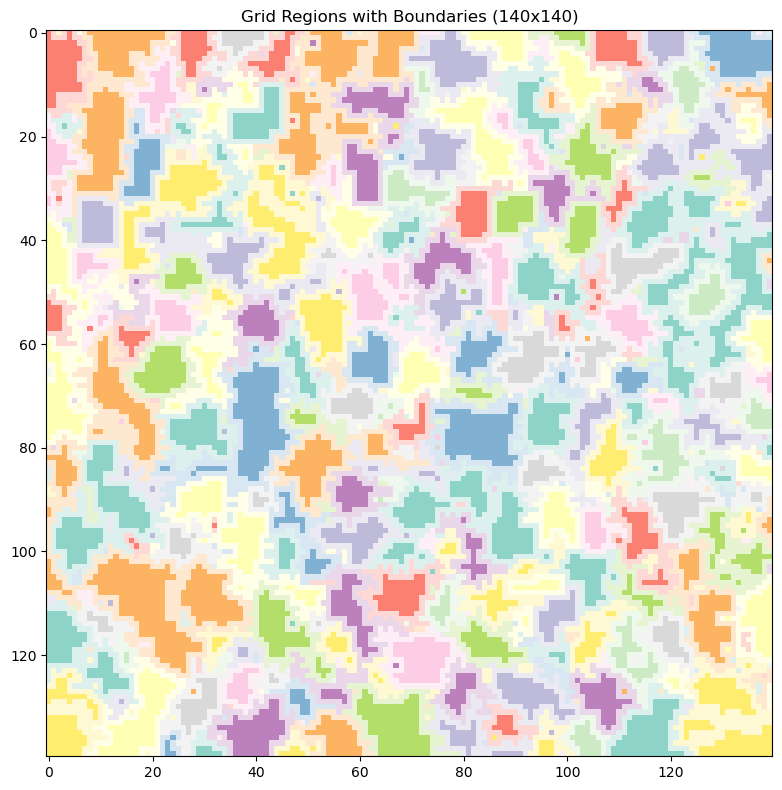

In [10]:
from scipy import ndimage
import matplotlib.pyplot as plt

def plot_grid_with_boundaries(grid):
    rows, cols = grid.shape
    unique_labels = np.unique(grid)
    label_to_num = {label: i for i, label in enumerate(unique_labels)}
    numeric_grid = np.vectorize(label_to_num.get)(grid)
    
    # Detect boundaries using gradient
    sobel_h = ndimage.sobel(numeric_grid, axis=0)
    sobel_v = ndimage.sobel(numeric_grid, axis=1)
    boundaries = np.hypot(sobel_h, sobel_v) > 0
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    cmap = plt.colormaps.get_cmap('Set3').resampled(len(unique_labels))
    ax.imshow(numeric_grid, cmap=cmap, interpolation='nearest')
    
    # Overlay boundaries in black
    ax.imshow(np.ma.masked_where(~boundaries, boundaries), 
              cmap='binary', alpha=0.7, interpolation='nearest')
    
    ax.set_title(f'Grid Regions with Boundaries ({rows}x{cols})')
    plt.tight_layout()
    plt.show()


plot_grid_with_boundaries(grid)